## Setup

In [1]:
!pip install tensorflow_addons
!pip install tensorflow_datasets

     |████████████████████████████████| 1.1 MB 4.1 MB/s 


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE

kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)


# Building blocks
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


# Generator
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
    out_channel=3,
    in_size = (480, 640, 3)
):
    img_input = layers.Input(shape=in_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(out_channel, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model


# Discriminator
def get_discriminator(
    filters=64,
    kernel_initializer=kernel_init,
    num_downsampling=3,
    name=None,
    in_size = (480,640,3)
):
    img_input = layers.Input(shape=in_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# CycleGAN
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.rms = tf.keras.metrics.RootMeanSquaredError()

    def train_step(self, batch_data):
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # x -> y
            fake_y = self.gen_G(real_x, training=True)
            # y -> x
            fake_x = self.gen_F(real_y, training=True)

            # x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )
        
        self.rms.reset_state()
        self.rms.update_state(real_y, fake_y)
        rms = self.rms.result()

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
            "RMS": rms
        }

## Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

newpath = r'drive/MyDrive/Colab Notebooks/DL/project' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

os.chdir('drive/MyDrive/Colab Notebooks/DL/project')
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/DL/project


### Train data prepration

In [5]:
import cv2

# loading
with open('images.npy', 'rb') as f:
    images = np.load(f)
    P = np.random.permutation(len(images))
    images = images[P[:1100]]

with open('depths.npy', 'rb') as f:
    depths = np.expand_dims(np.load(f),axis=3)[P[:1100]]

print(images.shape, depths.shape)

# Resize
ratio = 0.25
images = list(images)
depths = list(depths)

for i in range(len(images)):
    images[i] = cv2.resize(images[i],None,fx=ratio,fy=ratio)

for i in range(len(depths)):
    depths[i] = cv2.resize(depths[i],None,fx=ratio,fy=ratio)

images = np.array(images)
depths = np.expand_dims(np.array(depths),axis=3)

print(images.shape, depths.shape)

# normalization
images = images / 127.5 - 1
depths = depths / 127.5 - 1

# TF dataset
img_ds = tf.constant(images)
dep_ds = tf.constant(depths)
img_ds = tf.data.Dataset.from_tensor_slices(img_ds).cache().shuffle(256)
img_ds = img_ds.batch(batch_size=1)
dep_ds = tf.data.Dataset.from_tensor_slices(dep_ds).cache().shuffle(256)
dep_ds = dep_ds.batch(batch_size=1)
print(img_ds, dep_ds)

(1100, 480, 640, 3) (1100, 480, 640, 1)
(1100, 120, 160, 3) (1100, 120, 160, 1)
<BatchDataset shapes: (None, 120, 160, 3), types: tf.float64> <BatchDataset shapes: (None, 120, 160, 1), types: tf.float64>


### Test data prepration

In [6]:
# loading
with open('images.npy', 'rb') as f:
    te_images = np.load(f)[P[1100:]]

with open('depths.npy', 'rb') as f:
    te_depths = np.expand_dims(np.load(f),axis=3)[P[1100:]]

# Resize
te_images = list(te_images)
te_depths = list(te_depths)
for i in range(len(te_images)):
    te_images[i] = cv2.resize(te_images[i],None,fx=ratio,fy=ratio)

for i in range(len(te_depths)):
    te_depths[i] = cv2.resize(te_depths[i],None,fx=ratio,fy=ratio)

te_images = np.array(te_images)
te_depths = np.expand_dims(np.array(te_depths),axis=3)
print (te_images.shape, te_depths.shape)

# Normalization
te_images = te_images/127.5 - 1
te_depths = te_depths/127.5 - 1

# TF dataset
te_img_ds = tf.constant(te_images)
te_dep_ds = tf.constant(te_depths)
te_img_ds = tf.data.Dataset.from_tensor_slices(te_img_ds).cache().shuffle(256)
te_img_ds = te_img_ds.batch(batch_size=5)
te_dep_ds = tf.data.Dataset.from_tensor_slices(te_dep_ds).cache().shuffle(256)
te_dep_ds = te_dep_ds.batch(batch_size=5)
print (img_ds, dep_ds)

(349, 120, 160, 3) (349, 120, 160, 1)
<BatchDataset shapes: (None, 120, 160, 3), types: tf.float64> <BatchDataset shapes: (None, 120, 160, 1), types: tf.float64>


## G and D

In [7]:
size_X = (120,160,3)
size_Y = (120,160,1)

# Get the generators
gen_G = get_resnet_generator (
    filters=48,
    num_downsampling_blocks=2,
    num_residual_blocks=5,
    num_upsample_blocks=2,
    name="generator_G",
    in_size=size_X,
    out_channel=1
)

gen_F = get_resnet_generator (
    filters=48,
    num_downsampling_blocks=2,
    num_residual_blocks=5,
    num_upsample_blocks=2,
    name="generator_F",
    out_channel=3,
    in_size = size_Y
)

# Get the discriminators
disc_X = get_discriminator(
    filters=48,
    num_downsampling=3,
    name = "discriminator_X",
    in_size = size_X
)

disc_Y = get_discriminator(
    filters=48,
    num_downsampling=3,
    in_size = size_Y,
    name="discriminator_Y"
)

In [8]:
gen_G.summary()

Model: "generator_G"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 generator_G_img_input (InputLa  [(None, 120, 160, 3  0          []                               
 yer)                           )]                                                                
                                                                                                  
 reflection_padding2d (Reflecti  (None, 126, 166, 3)  0          ['generator_G_img_input[0][0]']  
 onPadding2D)                                                                                     
                                                                                                  
 conv2d (Conv2D)                (None, 120, 160, 48  7056        ['reflection_padding2d[0][0]']   
                                )                                                       

## Callbacks

In [9]:
class GANMonitor(keras.callbacks.Callback):
    # A callback to generate and save images after each epoch
    def __init__(self, path, num_img=4):
        self.num_img = num_img
        self.path = path

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(te_img_ds.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction.squeeze())
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                self.path + "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()

class WeightCheckpoint(keras.callbacks.Callback):
    # A callback for saving weights at the end of each epoch
    def __init__(self, path):
        self.path = path

    def on_epoch_end(self, epoch, logs=None):
        self.model.save_weights(self.path + f'weights_epoch_{epoch+1}')

## Training model

In [14]:
from datetime import datetime as dt

adv_loss_fn = keras.losses.MeanSquaredError()

def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss

def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

# Callbacks
now = dt.now()
check_path = f'./Run_{now.strftime("%d_%H_%M")}/'
print(now, check_path)

if not os.path.exists(check_path):
    os.makedirs(check_path)

plotter = GANMonitor(path=check_path)
checkpointer = WeightCheckpoint(path=check_path)

2022-02-04 15:28:16.381442 ./Run_04_15_28/


Epoch 1/10
1100/1100 [==============================] - ETA: 0s - G_loss: 2.0620 - F_loss: 3.9627 - D_X_loss: 0.1399 - D_Y_loss: 0.2030 - RMS: 0.2897

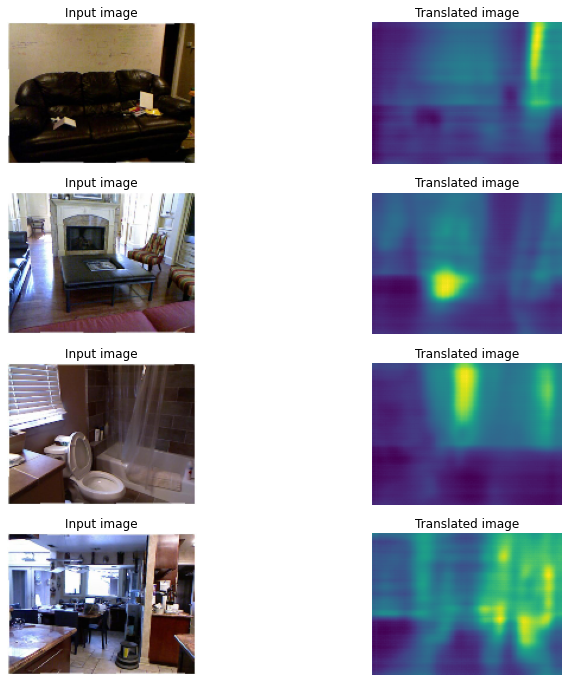

1100/1100 [==============================] - 356s 283ms/step - G_loss: 2.0616 - F_loss: 3.9634 - D_X_loss: 0.1398 - D_Y_loss: 0.2030 - RMS: 0.2896
Epoch 2/10
1100/1100 [==============================] - ETA: 0s - G_loss: 2.0069 - F_loss: 3.8052 - D_X_loss: 0.1482 - D_Y_loss: 0.1978 - RMS: 0.2700

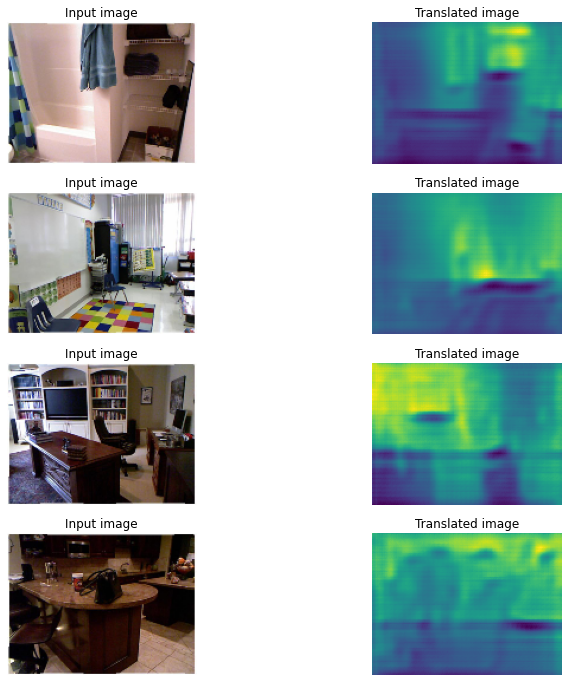

1100/1100 [==============================] - 313s 285ms/step - G_loss: 2.0065 - F_loss: 3.8054 - D_X_loss: 0.1482 - D_Y_loss: 0.1978 - RMS: 0.2699
Epoch 3/10
1100/1100 [==============================] - ETA: 0s - G_loss: 2.0900 - F_loss: 3.6864 - D_X_loss: 0.1302 - D_Y_loss: 0.1885 - RMS: 0.2699

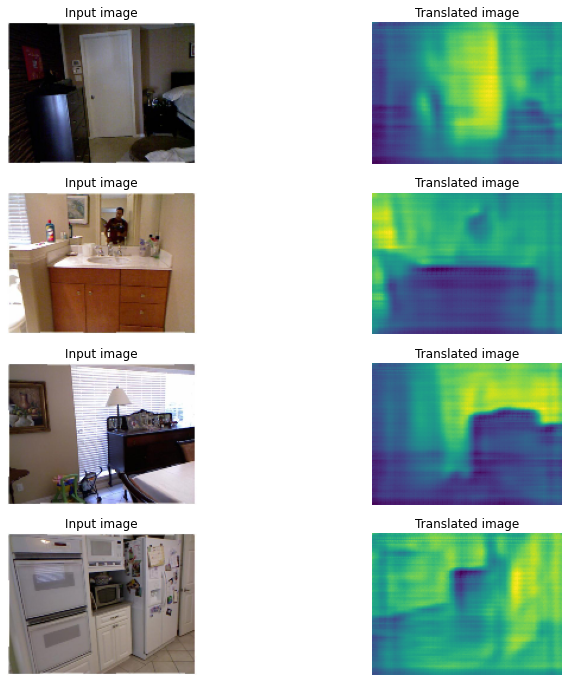

1100/1100 [==============================] - 316s 287ms/step - G_loss: 2.0897 - F_loss: 3.6866 - D_X_loss: 0.1301 - D_Y_loss: 0.1884 - RMS: 0.2699
Epoch 4/10
1100/1100 [==============================] - ETA: 0s - G_loss: 2.0158 - F_loss: 3.5265 - D_X_loss: 0.1084 - D_Y_loss: 0.2000 - RMS: 0.2727

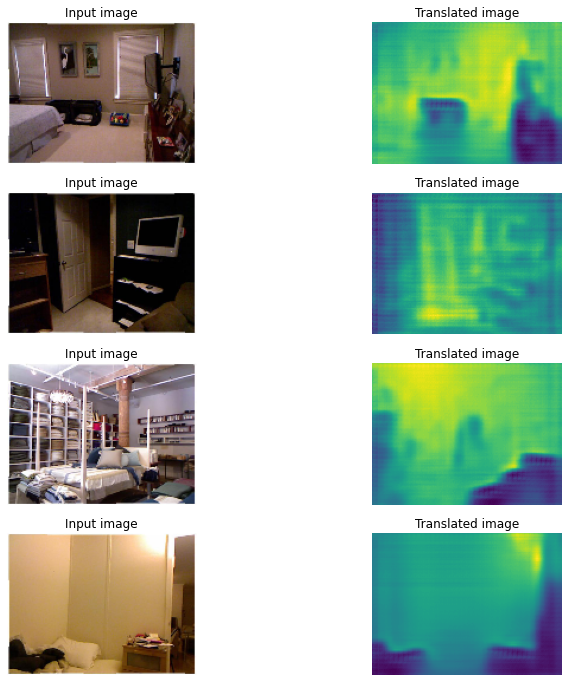

1100/1100 [==============================] - 318s 289ms/step - G_loss: 2.0158 - F_loss: 3.5265 - D_X_loss: 0.1084 - D_Y_loss: 0.1999 - RMS: 0.2727
Epoch 5/10
1100/1100 [==============================] - ETA: 0s - G_loss: 1.9881 - F_loss: 3.4721 - D_X_loss: 0.0940 - D_Y_loss: 0.1996 - RMS: 0.2789

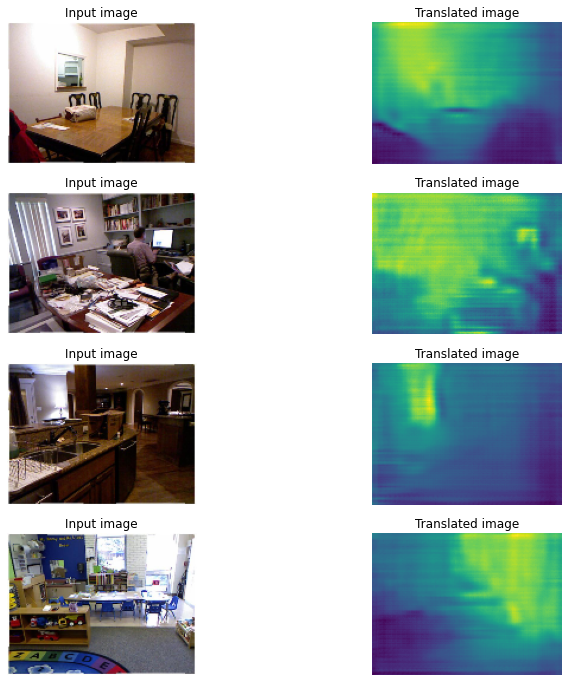

1100/1100 [==============================] - 317s 288ms/step - G_loss: 1.9871 - F_loss: 3.4714 - D_X_loss: 0.0940 - D_Y_loss: 0.1998 - RMS: 0.2787
Epoch 6/10
1100/1100 [==============================] - ETA: 0s - G_loss: 1.9377 - F_loss: 3.4000 - D_X_loss: 0.0884 - D_Y_loss: 0.2012 - RMS: 0.2832

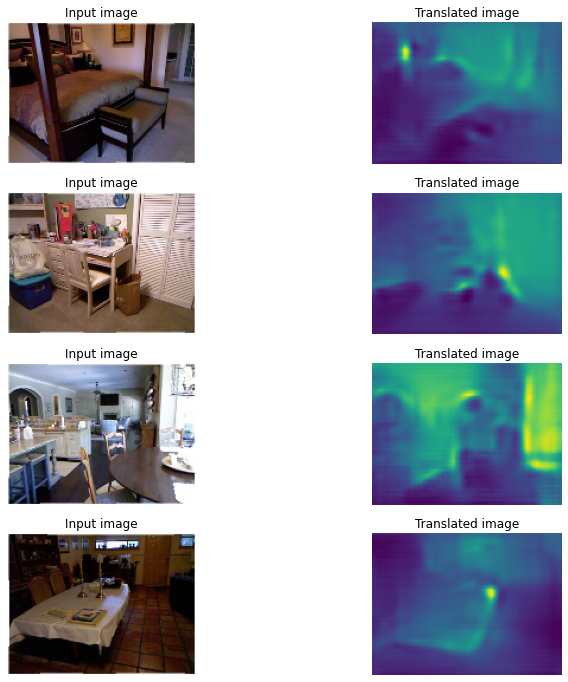

1100/1100 [==============================] - 317s 288ms/step - G_loss: 1.9376 - F_loss: 3.3993 - D_X_loss: 0.0884 - D_Y_loss: 0.2012 - RMS: 0.2832
Epoch 7/10
1100/1100 [==============================] - ETA: 0s - G_loss: 1.9075 - F_loss: 3.4628 - D_X_loss: 0.0911 - D_Y_loss: 0.2038 - RMS: 0.2844

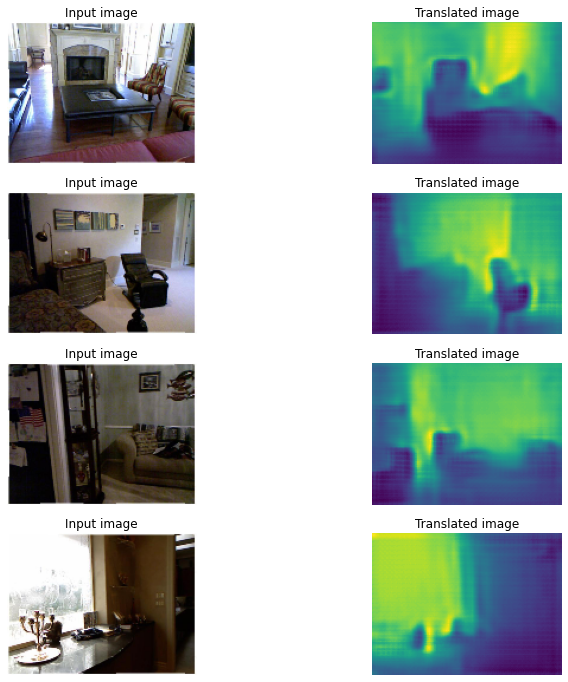

1100/1100 [==============================] - 316s 288ms/step - G_loss: 1.9065 - F_loss: 3.4623 - D_X_loss: 0.0912 - D_Y_loss: 0.2039 - RMS: 0.2843
Epoch 8/10
1100/1100 [==============================] - ETA: 0s - G_loss: 1.8820 - F_loss: 3.5305 - D_X_loss: 0.0902 - D_Y_loss: 0.2057 - RMS: 0.2822

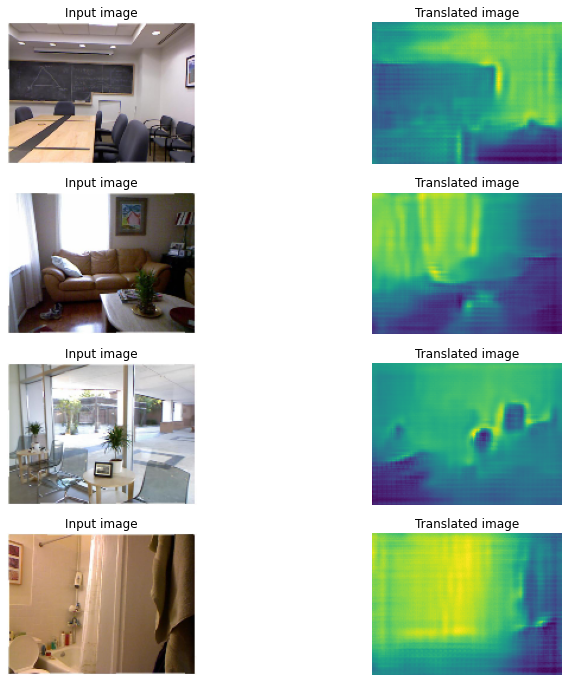

1100/1100 [==============================] - 317s 288ms/step - G_loss: 1.8863 - F_loss: 3.5316 - D_X_loss: 0.0903 - D_Y_loss: 0.2057 - RMS: 0.2826
Epoch 9/10
1100/1100 [==============================] - ETA: 0s - G_loss: 1.8295 - F_loss: 3.6079 - D_X_loss: 0.0797 - D_Y_loss: 0.2057 - RMS: 0.2898

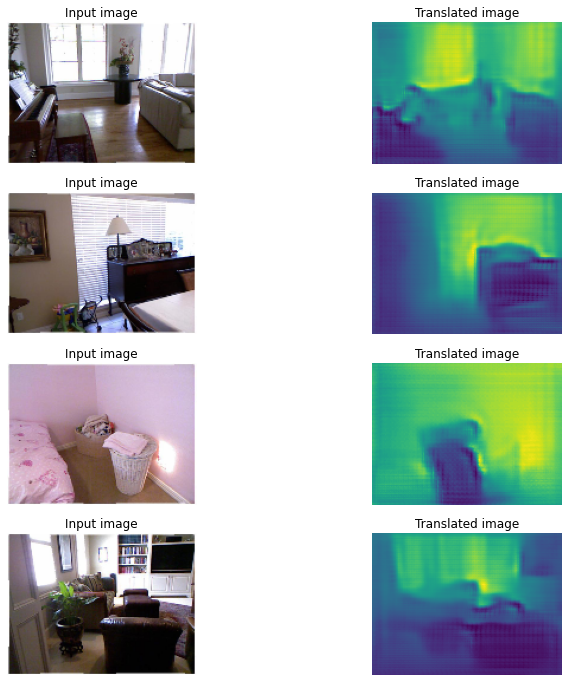

1100/1100 [==============================] - 318s 289ms/step - G_loss: 1.8295 - F_loss: 3.6069 - D_X_loss: 0.0798 - D_Y_loss: 0.2058 - RMS: 0.2897
Epoch 10/10
1100/1100 [==============================] - ETA: 0s - G_loss: 1.7392 - F_loss: 3.6082 - D_X_loss: 0.0699 - D_Y_loss: 0.2087 - RMS: 0.2949

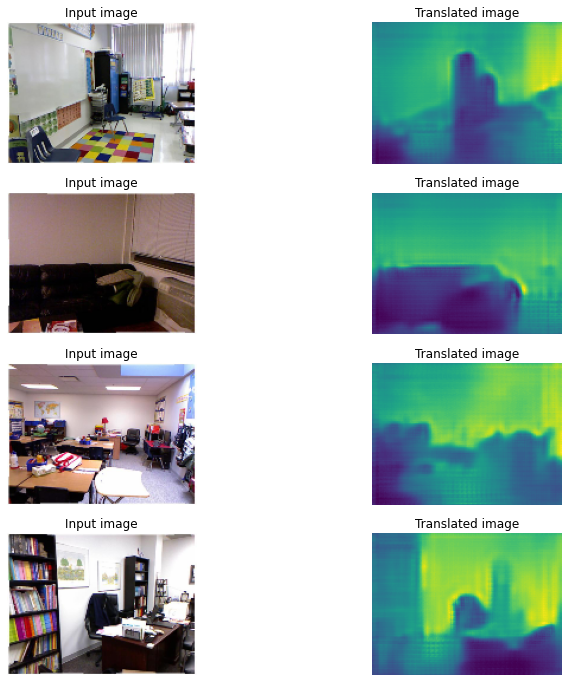

1100/1100 [==============================] - 318s 289ms/step - G_loss: 1.7388 - F_loss: 3.6077 - D_X_loss: 0.0699 - D_Y_loss: 0.2087 - RMS: 0.2949


In [15]:
hist = cycle_gan_model.fit(
    tf.data.Dataset.zip((img_ds, dep_ds)),
    epochs=10,
    callbacks=[plotter, checkpointer]
)

## Predictions

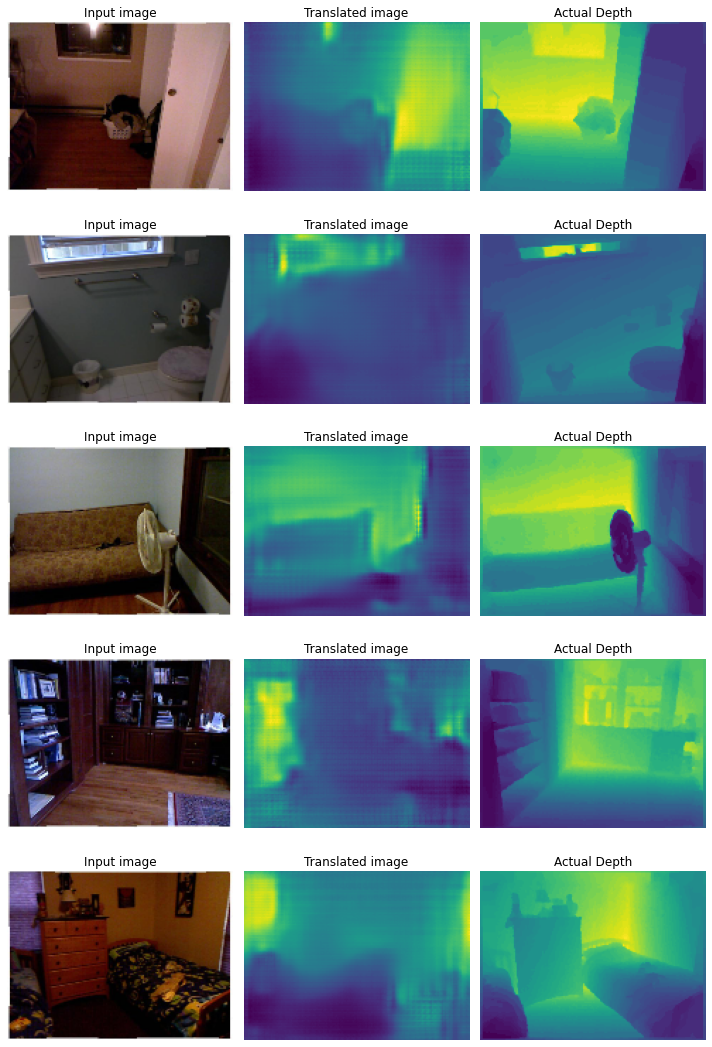

In [16]:
_, ax = plt.subplots(5, 3, figsize=(10, 15))

for i in range(5):
    img = te_images[10*i:10*i+1]
    prediction = cycle_gan_model.gen_G(img, training=False)[0]
    prediction = (prediction * 127.5 + 127.5).numpy().astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).astype(np.uint8)
    dep = (te_depths[10*i]*127.5 + 127.5).astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction.squeeze())
    ax[i, 2].imshow(dep.squeeze())
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 2].set_title("Actual Depth")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")

plt.tight_layout()
plt.show()